In [2]:
from tqdm import tqdm
import uproot
import numpy as np
import vector
import awkward as ak

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [57]:
path = "delphes_3169878_16.root:Delphes"
tree = uproot.open(path)

In [98]:
eta=ak.flatten(tree["Jet/Jet.Eta"].array(library="ak"))

(array([  1437.,   9162.,  38529.,  90387., 130234., 129440.,  89283.,
         36927.,   8715.,   1376.]),
 array([-4.92984819, -3.94128299, -2.95271778, -1.96415269, -0.97558755,
         0.0129776 ,  1.00154281,  1.99010789,  2.97867298,  3.96723819,
         4.95580339]),
 <BarContainer object of 10 artists>)

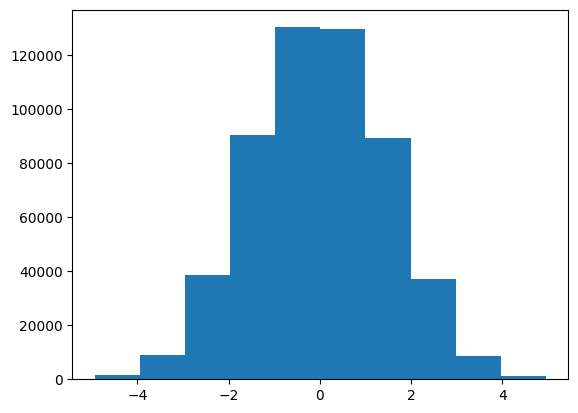

In [99]:
plt.hist(eta)

In [58]:
jet_pt=tree["Jet/Jet.PT"].array()
jet_eta=tree["Jet/Jet.Eta"].array()
jet_phi=tree["Jet/Jet.Phi"].array()
jet_mass=tree["Jet/Jet.Mass"].array()
track_pt=tree["Track/Track.PT"].array()
track_eta=tree["Track/Track.Eta"].array()
track_phi=tree["Track/Track.Phi"].array()
track_mass=tree["Track/Track.Mass"].array()

In [59]:
btagged_jets = tree["Jet/Jet.BTag"].array()
is_btagged = tree["Jet/Jet.BTag"].array()==1
_2btagged  = np.sum(btagged_jets, axis=1) == 2
jet_vector = vector.zip({'pt': jet_pt, 'eta': jet_eta, 'phi': jet_phi, 'm': jet_mass})[_2btagged]

In [60]:
track_vector = vector.zip({'pt': track_pt, 'eta': track_eta, 'phi': track_phi, 'm': track_mass})[_2btagged]

In [61]:
jet_vector_2btagged = jet_vector[is_btagged[_2btagged]]

In [65]:
track_vector1 = track_vector[jet_vector_2btagged[:,0].deltaR(track_vector) < 0.4]
track_vector2 = track_vector[jet_vector_2btagged[:,1].deltaR(track_vector) < 0.4]

In [66]:
def pull1(track1,jet1):
    # def delta_phi_func(u,v): return np.arctan2(np.sin(u.phi-v.phi),np.cos(u.phi-v.phi))
    
    delta_rapidity = track1.rapidity - jet1.rapidity
    # delta_phi      = delta_phi_func(track1 , jet1)
    delta_phi      = track1.deltaphi(jet1)
    
    coef              = track1.pt * np.sqrt(delta_phi**2 + delta_rapidity**2)
    constituent_pulls =  coef*vector.zip({'x': delta_rapidity, 'y': delta_phi})
    
    return np.sum(constituent_pulls,axis=1)/jet1.pt

In [77]:
out1=pull1(track_vector1,jet_vector_2btagged[:,0])
out2=pull1(track_vector2,jet_vector_2btagged[:,1])

In [103]:
np.amin(np.arctan2(out2.y,out2.x))

-3.1415198

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.   , 0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024,
        0.027, 0.03 ]),
 <BarContainer object of 10 artists>)

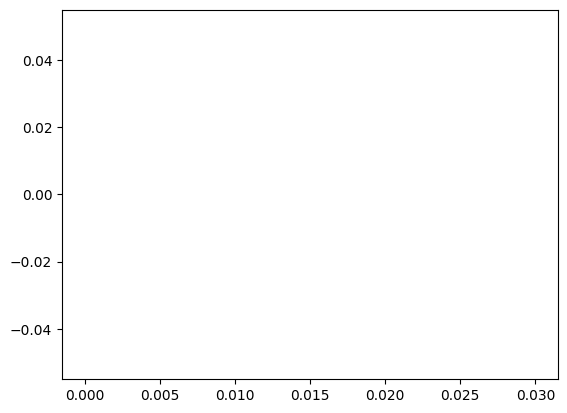

In [84]:
plt.hist(mag(p1),range=[0,0.03])

(array([3581., 4480., 5349., 4480., 3521., 3548., 4503., 5365., 4555.,
        3528.]),
 array([-3.14126611e+00, -2.51298022e+00, -1.88469434e+00, -1.25640857e+00,
        -6.28122687e-01,  1.63197517e-04,  6.28449082e-01,  1.25673497e+00,
         1.88502073e+00,  2.51330662e+00,  3.14159250e+00]),
 <BarContainer object of 10 artists>)

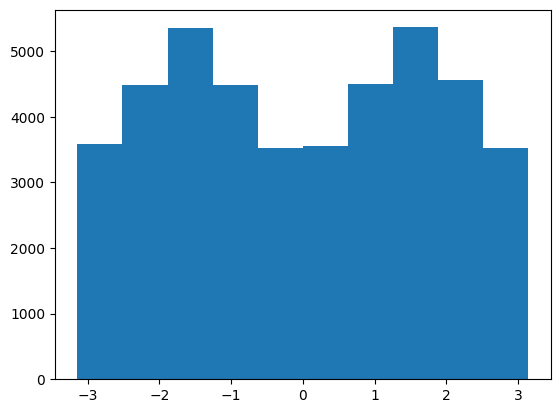

In [36]:
plt.hist(np.arctan2(out1.y,out1.x))

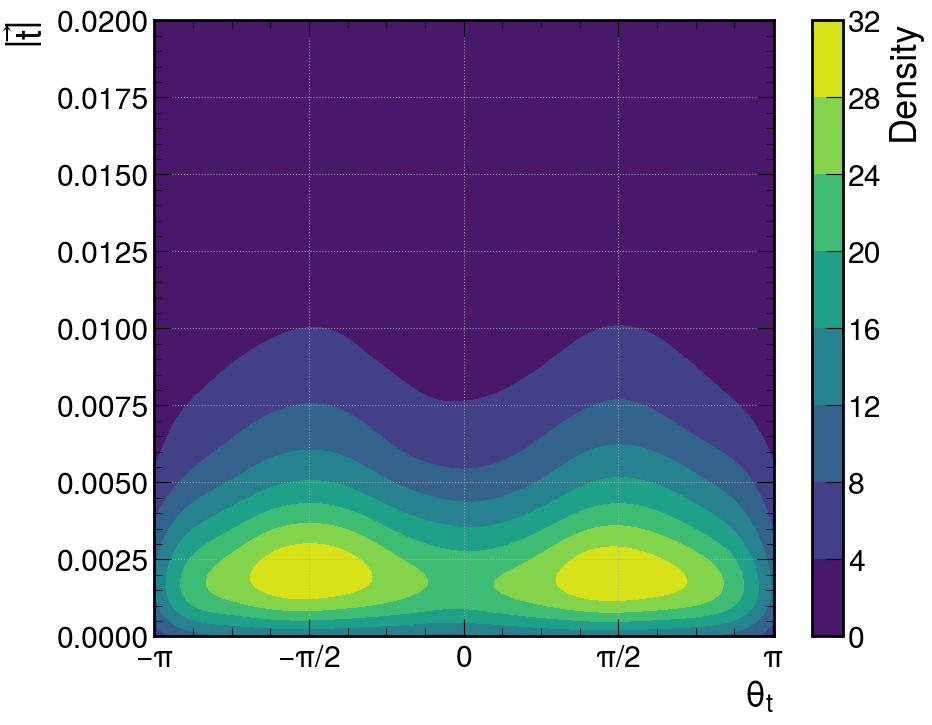

In [103]:
from scipy.interpolate import griddata
import mplhep as hep
hep.style.use("CMS") # string aliases work too
# x = np.arctan2(pull_jet_1.x,pull_jet_1.y)
xy = np.vstack([np.arctan2(out1.y,out1.x), mag(out1)])
kde = gaussian_kde(xy)
xmin, xmax = -3.15, 3.15
ymin, ymax = 0, 0.02

# Create a grid over the range of the data
theta_grid = np.linspace(xmin, xmax, 100)
pull_grid = np.linspace(ymin, ymax, 100)
theta_mesh, pull_mesh = np.meshgrid(theta_grid, pull_grid)

# Evaluate KDE on the grid points
z_values = kde(np.vstack([theta_mesh.ravel(), pull_mesh.ravel()])).reshape(theta_mesh.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.contourf(theta_mesh, pull_mesh, z_values, levels=8, cmap='viridis')
plt.colorbar(label='Density')
plt.xticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels=[r"$-\pi$",r"$-\pi$/2",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.xlabel(r'$\theta_t$')
plt.ylabel(r'$\left| \vec{t} \right|$')
plt.grid(True)# plt.title('pull of jet 1 angle in polar coordinates')
plt.show()

In [12]:
def mag(out): return np.sqrt(out.x**2 + out.y**2)

In [79]:
jcv12 = vector.zip({'x': jet_vector_2btagged[:,0].rapidity - jet_vector_2btagged[:,1].rapidity,
                    'y': jet_vector_2btagged[:,0].deltaphi(jet_vector_2btagged[:,1])})

jcv21 = vector.zip({'x': jet_vector_2btagged[:,1].rapidity - jet_vector_2btagged[:,0].rapidity,
                    'y': jet_vector_2btagged[:,1].deltaphi(jet_vector_2btagged[:,0])})

In [80]:
theta_p12 = np.arctan2(out2.y,out2.x) - np.arctan2(jcv12.y,jcv12.x)

In [120]:
theta_p = np.arccos((out1.x*jcv12.x + out1.y*jcv12.y)/(mag(out1)*mag(jcv12)))
theta_p2 = np.arccos(out1.unit().x*jcv12.unit().x + out1.unit().y*jcv12.unit().y)

/usr/local/lib/python3.10/site-packages/awkward/_connect/numpy.py:396: RuntimeWarning: invalid value encountered in divide
  result = impl(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/awkward/_connect/numpy.py:396: RuntimeWarning: invalid value encountered in arccos
  result = impl(*args, **kwargs)


Text(0.5, 0, '$\\theta_P$')

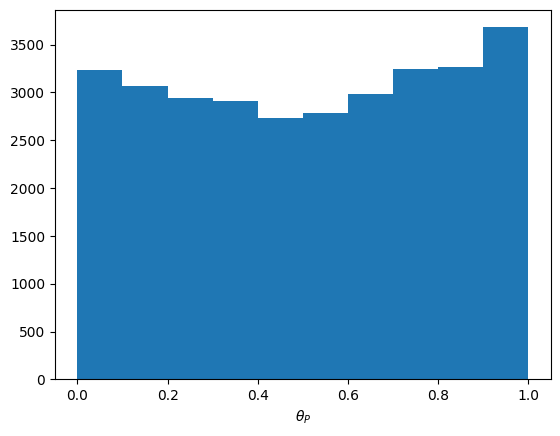

In [121]:
plt.hist(theta_p2/np.pi)
plt.xlabel(r"$\theta_P$")

In [109]:
xaxis = vector.zip({'x': np.ones(len(jet_vector_2btagged[:,1].rapidity)),"y":np.zeros(len(jet_vector_2btagged[:,1].rapidity))})


/usr/local/lib/python3.10/site-packages/awkward/_connect/numpy.py:396: RuntimeWarning: invalid value encountered in divide
  result = impl(*args, **kwargs)


(array([2481., 2613., 2945., 3500., 3738., 3861., 3529., 3015., 2639.,
        2497.]),
 array([4.55878000e-04, 3.14569556e-01, 6.28683233e-01, 9.42796911e-01,
        1.25691059e+00, 1.57102427e+00, 1.88513794e+00, 2.19925162e+00,
        2.51336530e+00, 2.82747898e+00, 3.14159265e+00]),
 <BarContainer object of 10 artists>)

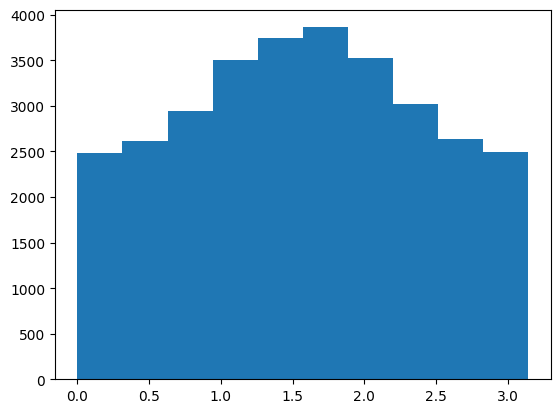

In [114]:
plt.hist(np.arccos((out1.x*xaxis.x + out1.y*xaxis.y)/mag(out1)))

In [116]:
def scalar_product_2D(u,v): return ((u.x*v.x + u.y*v.y)/np.sqrt(u.x*u.x + u.y*u.y)*np.sqrt(v.x*v.x + v.y*v.y))

/usr/local/lib/python3.10/site-packages/awkward/_connect/numpy.py:396: RuntimeWarning: invalid value encountered in divide
  result = impl(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/awkward/_connect/numpy.py:396: RuntimeWarning: invalid value encountered in arccos
  result = impl(*args, **kwargs)


(array([ 108.,  367.,  582.,  804.,  990., 1252.,  914.,  604.,  387.,
         121.]),
 array([0.00723416, 0.3196795 , 0.63212484, 0.94457018, 1.25701559,
        1.56946087, 1.88190627, 2.19435167, 2.50679684, 2.81924224,
        3.13168764]),
 <BarContainer object of 10 artists>)

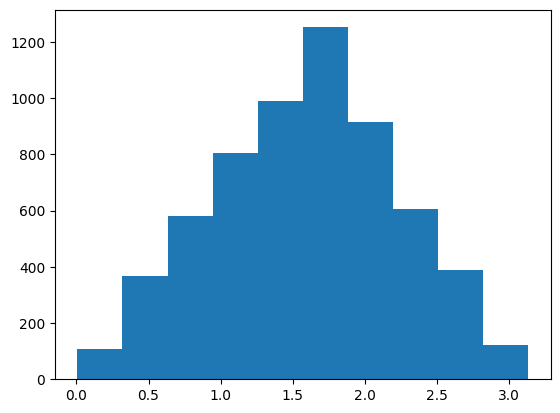

In [117]:
plt.hist(np.arccos(scalar_product_2D(out1,jcv12)))